# Few short learning with Siamese Networks

This notebook tries to classify images using Siamese Networks proposed by ***Gregory et. al***, in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), to solve the **One shot learning** problem.

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. [Keras](https://keras.io/) is used for implementing the CNN.

In the modern in which we live in Deep Learning has changed the way we use technology.

- Mobile applications like Google Photos with automatic Face Detection.
- Snapchat.
- Google Assistant/Siri.

All of these remarkable break throughs have been made possible by the power of Deep Learning.

Automatic face and tag detectionon on Facebook, every time we upload new image, has been made possible by training Deep Learning models on large amount of data.

Deep Learning models are performing so good in the current scenario because of the amount of data that is being generated each day. 


<img src="https://cdn-images-1.medium.com/max/800/1*ZX05x1xYgaVoa4Vn2kKS9g.png"></img>
<caption><center> <u> <font color='black'> **Figure 1** </u></center></caption>


Traditional Machine Learning approaches worked like the top half of the picture above. You would have to design a feature extraction algorithm which generally involved a lot of heavy mathematics (complex design), wasn’t very efficient, and didn’t perform too well at all (accuracy level just wasn’t suitable for real-world applications). After doing all of that you would also have to design a whole classification model to classify your input given the extracted features.

These models also fail to work with high dimensional data due to curse of dimensionality, in other words in high dimensional like Images, when fed into traditional machine learning models take a lot of time to find the right set of hyperparameters, though the number of hyperparameters is small but the number of feature space is so large that it will take a lot of time to train traditional machine learning models on such feature space.

Deep Learning on the other hand, using Neural Network architectures has been able to solve this problem.


## Few shot learning

One of the main requisites of highly accurate deep learning models is large amount of data.
The set of hyperparameters a Deep Model need to be tuned are very large, and the amount of data needed to get the right set of value for these hyperparameters is also large.

But what if we need an automated system, which can successfully classify images to various classes given the data for each image class is quite less.

**Few shot learning** is such a problem.
We can **Few shot learning** as a problem to classify data into K classes where each class has only few examples.
The paper written by [Gregory et. al](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), suggest ideas for building a Neural Network Architecture to solve this problem.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQThMusu8b2uK8kGwrFsg-cuZXaN8Wc7HkfgyiM-8YAfCfN_2uiJQ"></img>
<caption><center> <u> <font color='black'> **Figure 2** </u></center></caption>
The above image has been chosen from the Coursera course on Deep Learning by DeepLearning.ai
    
    
Machine learning has been successfully used to achieve state-ofthe-art
performance in a variety of applications such as
web search, spam detection, caption generation, and speech
and image recognition. However, these algorithms often
break down when forced to make predictions about data for
which little supervised information is available. We desire
to generalize to these unfamiliar categories without necessitating
extensive retraining which may be either expensive
or impossible due to limited data or in an online prediction
setting, such as web retrieval.

One particularly interesting task is classification under the
restriction that we may only observe a single example of
each possible class before making a prediction about a test
instance. This is called one-shot learning and it is the primary
focus of our model presented in this work

In [209]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

np.set_printoptions(threshold=np.nan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6449392955520690253
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 130482176
locality {
  bus_id: 1
}
incarnation: 16858197349399849285
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:00:05.0"
]


In [211]:
data_path = os.path.join('data/')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

In [212]:
base_class_name = 'character'

In [213]:
img = cv2.imread('data/images_background/Sanskrit/character11/0861_06.png')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (105, 105, 3)
The number of features in any image from the data set are: 33075


In [214]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

In [215]:
classes = gen_class_names(base_class_name)

In [216]:
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

In [217]:
labels = generate_one_hot_encoding(classes)

## Siamese Networks

Siamese network is a Deep Nueral Network architecture proposed by ***Gregory et. al*** in his paper [Siamese Neural Networks for One-shot Image Recognition](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), the paper proposes an architecture where using Convolutional Nueral Networks one can tackle the problem of One Shot Learning.

The model aims to solve the basic problem of **image verification**, given that we have very few samples of image of each class or category

The models aims to learn the embeddings of 2 separate images fed into the Nueral Network, the two embeddings are used to calculate the L1 distance between the 2 embeddings.
Once the distance embedding metric is calculated, the embedding is fed into a sigmoid unit which by the magic of back propogation, learns the correct set of hyperparameters to carry out the image verification.

<img src="https://sorenbouma.github.io/images/Siamese_diagram_2.png"></img>
<caption><center> <u> <font color='black'> **Figure 3**</font> </u></center></caption>


The model of Siamese network can be described as CNN architecture with 2 arms, a right arm and a left arm. The CNN architecture of a single arm has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having **0 mean 0.01 standard deviation**, also the bias hyperparameter of the these layers is initialized with a **mean value of 0.5 and a standard deviation of 0.01**.

The basic intuition that once can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.
 - If 2 images are similar the L1 distance between them will be lower as compared to the L1 distance computed for 2 somewhat different images.
 - The L1 distance computed is then used to train the sigmoid unit to find the write set of hyperparameters.

In [218]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

Text(0.5,1,'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

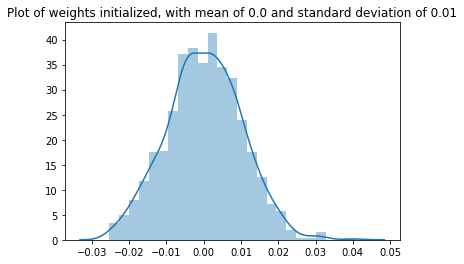

In [245]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [220]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5,1,'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

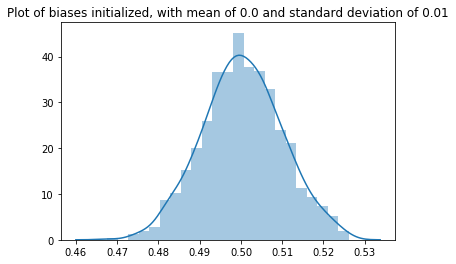

In [246]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [222]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [223]:
model = get_siamese_model((105, 105, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_70 (Sequential)      (None, 4096)         38947648    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_70[1][0]              
          

### Optimizing function and loss function
The training was initially done using Stochastic gradient descent(as described in the paper) with a learning rate 0.0005(choosen randomly between 0.01 and 0.00001) initially, due to which the convergence of model was very slow, after 3000 iterations the validation decreased from .47 to .43, where when the training was done using Adam's algorithm to optimize the training process even though with a smaller learning rate of 0.00006, the decrease in the validation loss was much faster as compared to simple Stochastic Gradient Descent.



In [248]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Image Verification and Recognition

Image verification is the task to find whether 2 images fed as input belong to the class/person or category.
Image verification differs from Image Recognition, where in Image Verification is 1:1 classification problem and Image Recognition is a 1:K classifcation problem, where K is the total number of classes present.

**Image Verification**
In Image Verification, you're given two images and you have to tell if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person/class.

<img src="https://image.ibb.co/k3P0hJ/pixel_comparison.png" style="width:380px;height:150px;"></img>
<caption><center> <u> <font color='black'> **Figure 4**</font> </u></center></caption>
    
    




**Face Recognition**
Facial recognition is a biometric solution that measures unique characteristics about one’s face. Applications available today include flight checkin, tagging friends and family members in photos, and “tailored” advertising.

<img src="https://cdn-images-1.medium.com/max/800/1*wh1N-kogDMaZYS17lqyqeQ.jpeg"></img>
<caption><center> <u> <font color='black'> **Figure 5**</font> </u></center></caption>

## Dataset

<img src="https://cdn-images-1.medium.com/max/1600/1*fRd4Sc6cT0_KFm6IhB3Bqw.png"></img>
<caption><center> <u> <font color='black'> **Figure 6**</font> </u></center></caption>

To demonstrate few shot [Omniglot dataset](https://github.com/brendenlake/omniglot) is used, Omniglot of Lake et al. is a MNIST-like scribbles dataset with 1623 characters with 20 examples each. The large number of classes (characters) with relatively few data per class (20), makes this an ideal data set for testing few-shot classification.

The figures below show few of the samples from the dataset.

In [225]:
def plot_images(path):
    """
        Plot all 20 samples of a particular character of a language
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = []
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        images_list.append(img)
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list.pop())

Arcadian language, 20 samples of the third character.


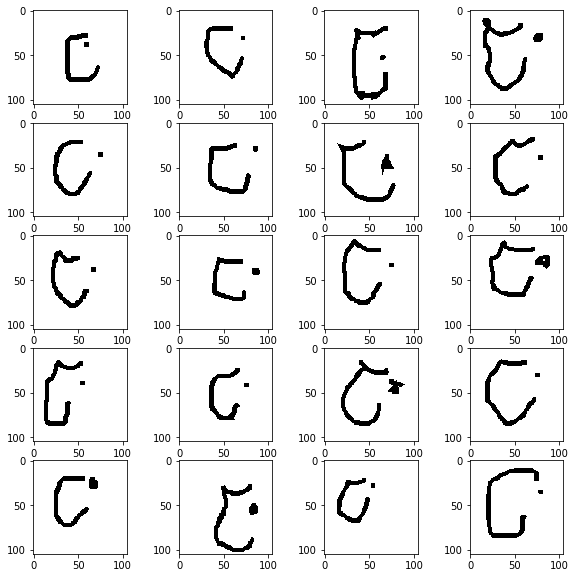

In [226]:
plot_images(os.path.join(data_path, 'images_background/Arcadian/character03/'))
print("Arcadian language, 20 samples of the third character.")

Korean language, 20 samples of the seventh character.


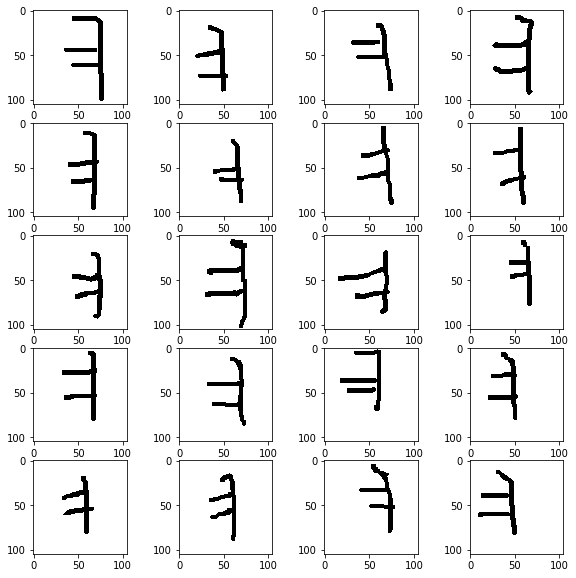

In [243]:
plot_images(os.path.join(data_path, 'images_background/Korean/character07/'))
print("Korean language, 20 samples of the seventh character.")

In [233]:
from load_data import *

loading alphabet: Cyrillic
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Gujarati
loading alphabet: Latin
loading alphabet: Burmese_(Myanmar)
loading alphabet: Japanese_(katakana)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Grantha
loading alphabet: Braille
loading alphabet: Early_Aramaic
loading alphabet: Tifinagh
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Arcadian
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Greek
loading alphabet: Japanese_(hiragana)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Futurama
loading alphabet: N_Ko
loading alphabet: Bengali
loading alphabet: Armenian
loading alphabet: Tagalog
loading alphabet: Korean
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Sanskrit
loading alphabet: Balinese
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Hebrew
loa

In [234]:
with open(os.path.join(data_path, "train.pickle"), "rb") as f:
    (X, classes) = pickle.load(f)

with open(os.path.join(data_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(classes.keys()))
print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Cyrillic', 'Syriac_(Estrangelo)', 'Gujarati', 'Latin', 'Burmese_(Myanmar)', 'Japanese_(katakana)', 'Mkhedruli_(Georgian)', 'Alphabet_of_the_Magi', 'Grantha', 'Braille', 'Early_Aramaic', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Arcadian', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Greek', 'Japanese_(hiragana)', 'Malay_(Jawi_-_Arabic)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Futurama', 'N_Ko', 'Bengali', 'Armenian', 'Tagalog', 'Korean', 'Anglo-Saxon_Futhorc', 'Sanskrit', 'Balinese', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Hebrew']
Validation alphabets:

['Glagolitic', 'Avesta', 'Aurek-Besh', 'Malayalam', 'Manipuri', 'ULOG', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Sylheti', 'Atlantean', 'Keble', 'Ge_ez', 'Mongolian', 'Tibetan', 'Atemayar_Qelisayer', 'Syriac_(Serto)', 'Gurmukhi', 'Tengwar', 'Oriya', 'Angelic']


### Training pipeline

In [235]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))
    

loader = Siamese_Loader(data_path)

loading data from data/train.pickle
loading data from data/val.pickle


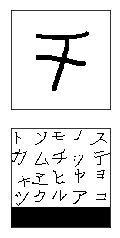

In [236]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)

In [237]:
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        
weights_path_2 = os.path.join(data_path, "model_weights.h5")
model.load_weights(weights_path_2)

### Testing pipeline 

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 96.88888888888889% 3 way one-shot learning accuracy 

Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 99.55555555555556% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 94.0% 5 way one-shot learning accuracy 

Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 99.77777777777777% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 5 way 

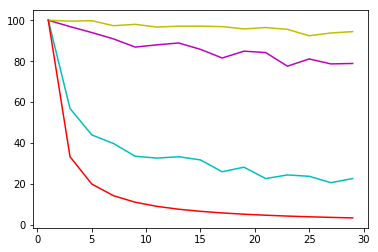

In [241]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(model, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

86.5481481481


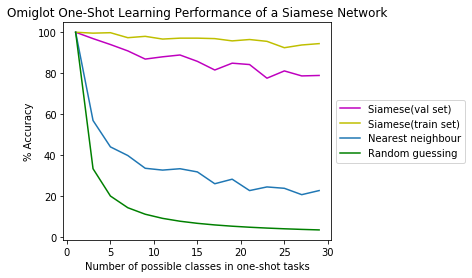

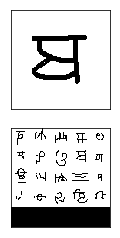

In [251]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20, "val")
plt.show()

plot_oneshot_task(inputs)

### Inference and Observations

The above model created seems to overfit a bit, one of the main reasons can be, the learning decay for each layer(as it is being mentioned in the original paper), has not been implemented in the current notebook.

Also one of the other reasons can be, is number of iterations during training time. Currently the model is being trained for 20,0000 iterations, one iteration being one full pass over the data set.

**Metric used to test the efficiency of the model**
Siamese Networks are mainly used to Image Verification.

Image Verification, being the task you're given two images and you have to tell if they are of the same person/class or category. Since in context of the problem we have in hand of image verification, classifying similar images of characters as same is the main problem we need to solve, therefore choosing ***accuracy*** is the right metric we should use to validate the performance of our model on new unseen data.